c:\Users\henri\anaconda3\envs\IntelSis\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


c:\Users\henri\anaconda3\envs\IntelSis\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


c:\Users\henri\anaconda3\envs\IntelSis\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\henri\anaconda3\envs\IntelSis\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\henri\anaconda3\envs\IntelSis\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Params: optimizer=adam, dropout_rate=0.2, activation=relu, batch_size=32, epochs=20 -> Accuracy: 0.9834, Precision: 0.9721, Recall: 0.9955, F1: 0.9836, ROC-AUC: 0.9955

Best Hyperparameters and Metrics:
Optimizer: adam
Dropout Rate: 0.2
Activation: relu
Batch Size: 32
Epochs: 20
Metrics: {'accuracy': 0.9834234745534104, 'precision': 0.9720926338321366, 'recall': 0.99546872691106, 'f1': 0.9836354782861377, 'roc_auc': 0.9954718800667541}
Epoch 1/20


c:\Users\henri\anaconda3\envs\IntelSis\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8384 - loss: 0.3664
Epoch 2/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9241 - loss: 0.2039
Epoch 3/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9342 - loss: 0.1768
Epoch 4/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9380 - loss: 0.1632
Epoch 5/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9483 - loss: 0.1393
Epoch 6/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9502 - loss: 0.1342
Epoch 7/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9600 - loss: 0.1074
Epoch 8/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9633 - loss: 0.1043
Epoch 9/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9676 - loss: 0.0997
Epoch 10/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9673 - loss: 0.0923
Epoch 11/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9656 - loss: 0.0942
Epoch 12/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

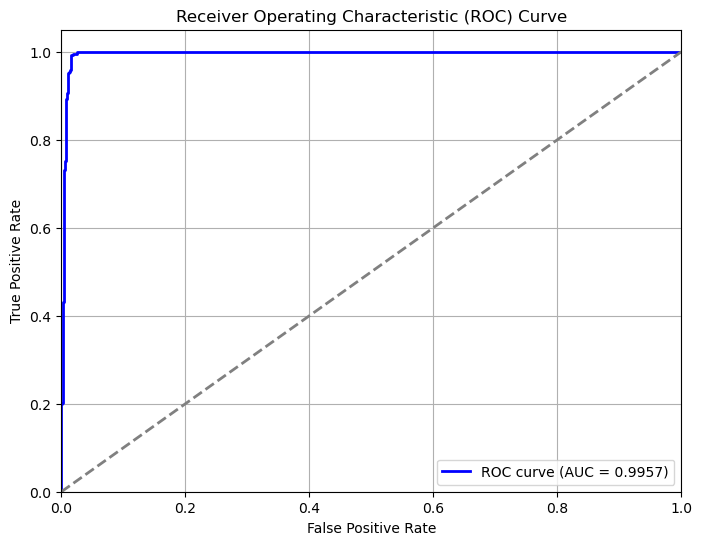

In [ ]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# Load the dataset
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Data preparation (Assuming the last column is the target variable)
X = train_data.iloc[:, :-1].values  # Convert to NumPy array
y = train_data.iloc[:, -1].values   # Convert to NumPy array
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

# Split train data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Define the model creation function
def create_model(optimizer, dropout_rate, activation):
    model = Sequential([
        Dense(128, activation=activation, input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(64, activation=activation),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the hyperparameter grid
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.2], 0.3, 0.4,
    'activation': ['relu'], 'tanh',
    'batch_size': [16, 32],
    'epochs': [10, 20]
}

# Generate all combinations of hyperparameters
hyperparameter_combinations = list(product(
    param_grid['optimizer'], 
    param_grid['dropout_rate'], 
    param_grid['activation'], 
    param_grid['batch_size'], 
    param_grid['epochs']
))

# Perform custom grid search
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_params = None
best_score = 0
best_metrics = {}

for (optimizer, dropout_rate, activation, batch_size, epochs) in hyperparameter_combinations:
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1_scores = []
    fold_roc_aucs = []
    
    for train_index, val_index in kf.split(X_train):
        # Split into train and validation folds
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        # Create and train the model
        model = create_model(optimizer, dropout_rate, activation)
        model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=0)
        
        # Evaluate on the validation fold
        y_val_pred_probs = model.predict(X_val_fold).flatten()
        y_val_pred = (y_val_pred_probs > 0.5).astype(int)
        
        # Compute metrics
        fold_accuracies.append(accuracy_score(y_val_fold, y_val_pred))
        fold_precisions.append(precision_score(y_val_fold, y_val_pred))
        fold_recalls.append(recall_score(y_val_fold, y_val_pred))
        fold_f1_scores.append(f1_score(y_val_fold, y_val_pred))
        fold_roc_aucs.append(roc_auc_score(y_val_fold, y_val_pred_probs))
    
    # Calculate mean metrics for this hyperparameter combination
    avg_accuracy = np.mean(fold_accuracies)
    avg_precision = np.mean(fold_precisions)
    avg_recall = np.mean(fold_recalls)
    avg_f1 = np.mean(fold_f1_scores)
    avg_roc_auc = np.mean(fold_roc_aucs)
    
    print(f"Params: optimizer={optimizer}, dropout_rate={dropout_rate}, activation={activation}, "
          f"batch_size={batch_size}, epochs={epochs} -> "
          f"Accuracy: {avg_accuracy:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, "
          f"F1: {avg_f1:.4f}, ROC-AUC: {avg_roc_auc:.4f}")
    
    # Update the best parameters if current combination is better
    if avg_accuracy > best_score:
        best_score = avg_accuracy
        best_params = (optimizer, dropout_rate, activation, batch_size, epochs)
        best_metrics = {
            'accuracy': avg_accuracy,
            'precision': avg_precision,
            'recall': avg_recall,
            'f1': avg_f1,
            'roc_auc': avg_roc_auc
        }

# Output the best hyperparameters and their score
print("\nBest Hyperparameters and Metrics:")
print(f"Optimizer: {best_params[0]}")
print(f"Dropout Rate: {best_params[1]}")
print(f"Activation: {best_params[2]}")
print(f"Batch Size: {best_params[3]}")
print(f"Epochs: {best_params[4]}")
print(f"Metrics: {best_metrics}")

# Train the final model using the best hyperparameters on the full training set
final_model = create_model(*best_params[:3])
final_model.fit(X_train, y_train, epochs=best_params[4], batch_size=best_params[3], verbose=1)

# Evaluate on the validation set
y_val_pred_probs = final_model.predict(X_val).flatten()
y_val_pred = (y_val_pred_probs > 0.5).astype(int)

val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_pred_probs)

print("\nValidation Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1-Score: {val_f1:.4f}")
print(f"ROC-AUC: {val_roc_auc:.4f}")

# === Plot ROC Curve at the Very End ===
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_val, y_val_pred_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=2)  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
